In [73]:
import pandas as pd
from scipy.io import arff
import os,sys

sys.path.append(os.path.abspath('../src'))
from src.data.load_data import load_arff_data

file_path = 'data\Supply Chain Management_train.arff'
df = load_arff_data(file_path)
target_features = [col for col in df.columns if col.startswith("MTLp") or col == "LBL"]
non_target_features = [col for col in df.columns if not (col.startswith("MTLp") or col == "LBL")]
print(f"total features = {len(non_target_features)}")
print(f"total target features = {len(target_features)}")
print(f"total rows = {len(df)}")
df.head()

total features = 280
total target features = 16
total rows = 8145


,timeunit,storageCost,interestRate,compidx0lt2,compidx0lt2l1,compidx0lt2l2,compidx0lt2l4,compidx0lt2l8,compidx1lt2,compidx2lt2,...,MTLp7,MTLp8,MTLp9,MTLp10,MTLp11,MTLp12,MTLp13,MTLp14,MTLp15,MTLp16
0,9.0,27.0,8.0,881.606,882.253,826.727,810.837,848.833,1468.412,815.832,...,2292.0,2181.0,1619.0,1849.0,1707.0,1932.0,2052.0,2409.0,2279.0,2138.0
1,10.0,27.0,8.0,869.455,881.606,882.253,802.480,770.544,1407.148,828.687,...,2276.0,2231.0,1649.0,1813.0,1696.0,1988.0,2140.0,2366.0,2307.0,2154.0
2,11.0,27.0,8.0,850.916,869.455,881.606,826.727,784.625,1424.312,837.975,...,2264.0,2203.0,1651.0,1739.0,1677.0,1991.0,2087.0,2295.0,2185.0,2131.0
3,12.0,27.0,8.0,862.066,850.916,869.455,882.253,792.403,1411.209,803.296,...,2279.0,2203.0,1627.0,1747.0,1669.0,1885.0,2072.0,2292.0,2187.0,2170.0
4,13.0,27.0,8.0,842.781,862.066,850.916,881.606,810.837,1428.685,813.118,...,2241.0,2198.0,1626.0,1740.0,1663.0,1874.0,2074.0,2257.0,2136.0,2164.0


Optimal PCs at: PC45


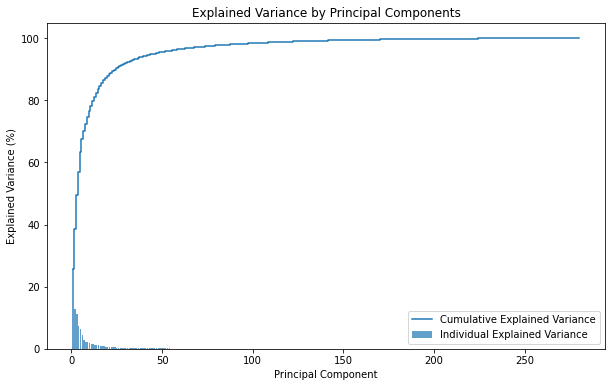

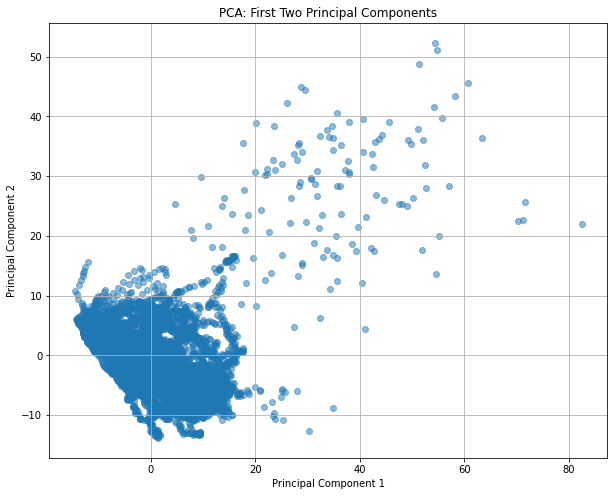

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


# Standardize the non-target features
scaler = StandardScaler()
non_target_data = df[non_target_features]
scaled_data = scaler.fit_transform(non_target_data)

# Apply PCA
pca = PCA(n_components=None,random_state=19)
pca_result = pca.fit_transform(scaled_data)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)
print(f"Optimal PCs at: PC{np.where(cumulative_variance > 95)[0][0]}")

# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label="Individual Explained Variance")
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where="mid", label="Cumulative Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance by Principal Components")
plt.legend(loc="best")
plt.show()

# Visualize the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Principal Components")
plt.grid(True)
plt.show()


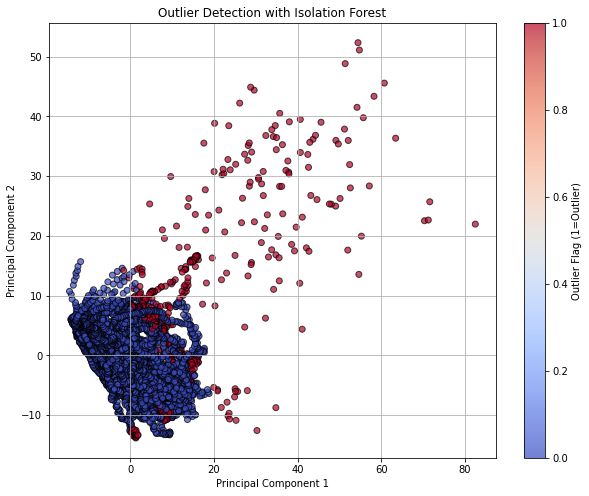

0    7737
1     408
Name: Outlier, dtype: int64

In [40]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for outlier detection on PCA-transformed data
# Using top 10 PCs for efficiency
isolation_forest = IsolationForest(random_state=42, contamination=0.05, n_estimators=100)
outliers = isolation_forest.fit_predict(pca_result[:, :10])

# Add outlier flag to the dataframe
df['Outlier'] = (outliers == -1).astype(int)

# Count the number of detected outliers
outlier_count = df['Outlier'].value_counts()

# Visualize outliers on the first two principal components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=df['Outlier'],
    cmap='coolwarm',
    alpha=0.7,
    edgecolor='k'
)
plt.colorbar(scatter, label="Outlier Flag (1=Outlier)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Outlier Detection with Isolation Forest")
plt.grid(True)
plt.show()

# Display outlier count
outlier_count


In [42]:
# Analyze the relationship between outliers and non-target features
outlier_analysis = df.groupby('Outlier')[non_target_features].mean()

# Analyze the relationship between outliers and target features
target_outlier_analysis = df.groupby('Outlier')[target_features].mean()

In [44]:
# Identify features with the largest differences between outliers and non-outliers
feature_diff = outlier_analysis.loc[1] - outlier_analysis.loc[0]
largest_diff_features = feature_diff.abs().sort_values(ascending=False).head(10)

# Analyze target features with the largest differences
target_diff = target_outlier_analysis.loc[1] - target_outlier_analysis.loc[0]
largest_diff_targets = target_diff.abs().sort_values(ascending=False).head(10)

# Display the features and targets with the largest differences for further analysis
largest_diff_features_df = feature_diff[largest_diff_features.index]
largest_diff_targets_df = target_diff[largest_diff_targets.index]


In [53]:
largest_diff_features_df

compidx3lt30      567.564105
compidx1lt30      556.845859
compidx0lt30      409.933816
compidx0lt30l1    394.020276
compidx2lt30      388.277300
compidx0lt30l2    370.926631
compidx0lt30l4    320.868842
compidx0lt30l8    314.616724
compidx4lt2       303.850306
compidx4lt2l1     297.373155
dtype: float64

In [54]:
largest_diff_targets_df

MTLp13    96.155933
MTLp15    79.645545
MTLp7     72.412609
MTLp5     63.033648
MTLp6     56.686015
MTLp3     55.558613
MTLp8     49.360058
MTLp9     43.553115
MTLp16    42.062251
LBL       37.402906
dtype: float64

In [ ]:
import pickle

#save PCA model
pca = PCA(n_components=45,random_state=19)
pca_result = pca.fit_transform(scaled_data)
with open('models/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)